# Loading packages

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

# Preparing the Network

In [ ]:

model = models.resnet50(weights="DEFAULT")
num_features = model.fc.in_features

model.fc = nn.Linear(in_features=num_features, out_features=2, bias=True)
nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0.0)

# The model weights are frozen except for the fully connected layer
model = model.requires_grad_(False)
model.fc.weight.requires_grad_(True)
model.fc.bias.requires_grad_(True)
pass

# Loading the data

In [ ]:
generator1 = torch.Generator().manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_all = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset_all = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Filter the dataset to include only 'plane' and 'car' classes
classes_of_interest = [0, 1] # plane, automobile
trainset = [item for i, item in enumerate(trainset_all) if trainset_all.targets[i] in classes_of_interest]
test_dataset = [item for i, item in enumerate(testset_all) if testset_all.targets[i] in classes_of_interest]

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# separate train and validation sets
val_portion = 0.2
validation_size = int(val_portion*len(trainset))
train_size = len(trainset) - validation_size
train_dataset, val_dataset = random_split(trainset, [train_size, validation_size])

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Training

Epoch [1/10], Train Loss: 0.5864, Train Accuracy: 70.00%
Validation Loss: 0.6175, Validation Accuracy: 78.40%
Epoch [2/10], Train Loss: 0.4729, Train Accuracy: 78.51%
Validation Loss: 0.4863, Validation Accuracy: 81.65%
Epoch [3/10], Train Loss: 0.4451, Train Accuracy: 80.41%
Validation Loss: 0.4708, Validation Accuracy: 82.40%
Epoch [4/10], Train Loss: 0.4212, Train Accuracy: 82.08%
Validation Loss: 0.4850, Validation Accuracy: 83.85%
Epoch [5/10], Train Loss: 0.4116, Train Accuracy: 82.36%
Validation Loss: 0.3735, Validation Accuracy: 84.75%
Epoch [6/10], Train Loss: 0.4148, Train Accuracy: 82.42%
Validation Loss: 0.3623, Validation Accuracy: 85.40%
Epoch [7/10], Train Loss: 0.3952, Train Accuracy: 83.16%
Validation Loss: 0.3859, Validation Accuracy: 83.35%
Epoch [8/10], Train Loss: 0.3995, Train Accuracy: 83.28%
Validation Loss: 0.4633, Validation Accuracy: 83.85%
Epoch [9/10], Train Loss: 0.4006, Train Accuracy: 82.73%
Validation Loss: 0.3756, Validation Accuracy: 84.90%
Epoch [10/

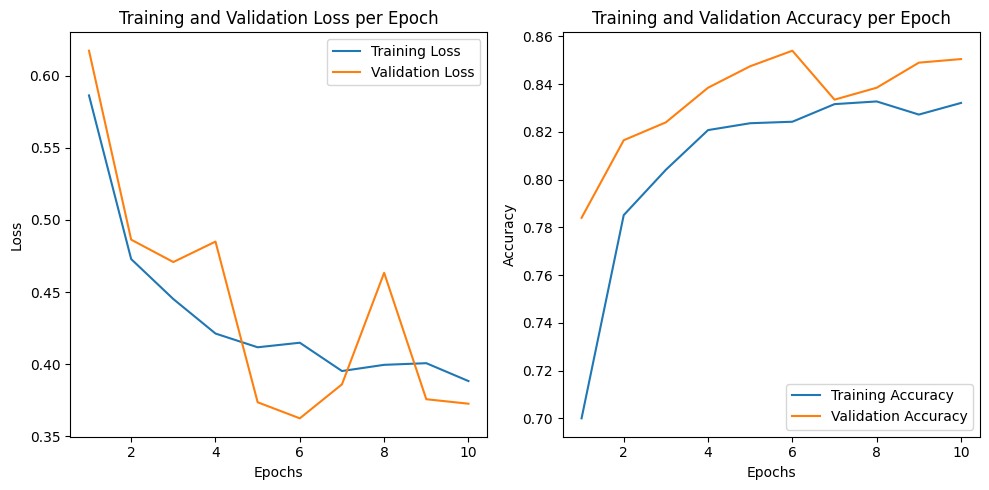

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)
criterion = nn.CrossEntropyLoss()

epochs = 10  # Change the number of epochs as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for i, data in enumerate(trainloader):

        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        # print(outputs)
        loss.backward()
        optimizer.step()

        # Calculate training loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_accuracy = correct / total

    train_loss_values.append(epoch_train_loss)
    train_accuracy_values.append(epoch_train_accuracy)

    print(f"Epoch [{epoch + 1}/{epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Accuracy: {100 * epoch_train_accuracy:.2f}%")

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_data in valloader:
            val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

    epoch_val_loss = val_running_loss / len(valloader)
    epoch_val_accuracy = val_correct / val_total

    val_loss_values.append(epoch_val_loss)
    val_accuracy_values.append(epoch_val_accuracy)

    print(f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {100 * epoch_val_accuracy:.2f}%")

print("Finished Training")

# Calculate accuracy on test dataset
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_data in testloader:
        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {100 * test_accuracy:.2f}%")


# Plotting accuracy and loss per epoch
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracy_values, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'saved_model_state_dict.pth')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mkdir '/content/drive/MyDrive/DeepHW/'
torch.save(model.state_dict(), '/content/drive/MyDrive/DeepHW/q1_model_state_dict.pth')

# Triplet Loss

In [14]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
import random

In [20]:
# Refining the architecture

model = models.resnet50(weights="DEFAULT")


# Remove the fc layer in the end of the model to create the feature extractor
feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))
pass

## Dataset

In [16]:
# Load CIFAR-10 dataset and filter it to contain planes and automobiles only
generator1 = torch.Generator().manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_all = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset_all = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Filter the dataset to include only 'plane' and 'car' classes
classes_of_interest = [0, 1] # plane, automobile
trainset = [item for i, item in enumerate(trainset_all) if trainset_all.targets[i] in classes_of_interest]
test_dataset = [item for i, item in enumerate(testset_all) if testset_all.targets[i] in classes_of_interest]

# separate train and validation sets
val_portion = 0.2
validation_size = int(val_portion*len(trainset))
train_size = len(trainset) - validation_size
train_dataset, val_dataset = random_split(trainset, [train_size, validation_size])


class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.dataset[idx]

        # Select a positive sample from the same class
        positive_img = random.choice([data[0] for data in self.dataset if data[1] == anchor_label])

        # Select a negative sample from a different class
        negative_img = random.choice([data[0] for data in self.dataset if data[1] != anchor_label])

        return anchor_img, positive_img, negative_img

# Create a dataset for triplet loss
triplet_dataset = TripletDataset(trainset)

# Create a dataloader for triplet loss
triplet_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Training the feature extractor

In [21]:
# Define the optimizer and TripletLoss
optimizer = optim.SGD(feature_extractor.parameters(), lr=0.01, momentum=0.9)

triplet_loss = nn.TripletMarginLoss()

# Training loop with triplet loss
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor.to(device)
feature_extractor.train()

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(triplet_loader):
        anchor, positive, negative = data[0].to(device), data[1].to(device), data[2].to(device)

        optimizer.zero_grad()

        # Forward pass
        output_anchor = feature_extractor(anchor)
        output_positive = feature_extractor(positive)
        output_negative = feature_extractor(negative)

        loss = triplet_loss(output_anchor, output_positive, output_negative)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], "
            f"Loss: {running_loss / len(triplet_loader):.4f}")
    running_loss = 0.0

print("Finished Training with Triplet Loss")


Epoch [1/5], Loss: 1.0077
Epoch [2/5], Loss: 1.0009
Epoch [3/5], Loss: 1.0003
Epoch [4/5], Loss: 1.0002
Epoch [5/5], Loss: 1.0001
Finished Training with Triplet Loss


# Training the complete model

In [25]:
num_features = model.fc.in_features

custom_fc = nn.Linear(in_features=num_features, out_features=2, bias=True)
nn.init.xavier_uniform_(custom_fc.weight)
custom_fc.bias.data.fill_(0.0)

# The model weights are frozen except for the fully connected layer
feature_extractor = feature_extractor.requires_grad_(False)

class CombinedModel(nn.Module):
    def __init__(self, backbone, custom_fc):
        super(CombinedModel, self).__init__()
        self.backbone = backbone
        self.custom_fc = custom_fc

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.custom_fc(x)
        return x

# Combine the models
combined_model = CombinedModel(feature_extractor, custom_fc)


In [23]:
generator1 = torch.Generator().manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_all = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset_all = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Filter the dataset to include only 'plane' and 'car' classes
classes_of_interest = [0, 1] # plane, automobile
trainset = [item for i, item in enumerate(trainset_all) if trainset_all.targets[i] in classes_of_interest]
test_dataset = [item for i, item in enumerate(testset_all) if testset_all.targets[i] in classes_of_interest]

# separate train and validation sets
val_portion = 0.2
validation_size = int(val_portion*len(trainset))
train_size = len(trainset) - validation_size
train_dataset, val_dataset = random_split(trainset, [train_size, validation_size])

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


Epoch [1/30], Train Loss: 0.6912, Train Accuracy: 52.05%
Validation Loss: 0.7020, Validation Accuracy: 51.15%
Epoch [2/30], Train Loss: 0.6891, Train Accuracy: 53.14%
Validation Loss: 0.7367, Validation Accuracy: 53.85%
Epoch [3/30], Train Loss: 0.6876, Train Accuracy: 53.66%
Validation Loss: 0.7197, Validation Accuracy: 53.35%
Epoch [4/30], Train Loss: 0.6875, Train Accuracy: 55.77%
Validation Loss: 0.7147, Validation Accuracy: 53.20%
Epoch [5/30], Train Loss: 0.6866, Train Accuracy: 55.26%
Validation Loss: 0.7167, Validation Accuracy: 55.75%
Epoch [6/30], Train Loss: 0.6851, Train Accuracy: 54.46%
Validation Loss: 0.7267, Validation Accuracy: 55.05%
Epoch [7/30], Train Loss: 0.6838, Train Accuracy: 55.67%
Validation Loss: 0.7525, Validation Accuracy: 55.25%
Epoch [8/30], Train Loss: 0.6835, Train Accuracy: 54.80%
Validation Loss: 0.7239, Validation Accuracy: 53.75%
Epoch [9/30], Train Loss: 0.6838, Train Accuracy: 55.73%
Validation Loss: 0.7257, Validation Accuracy: 56.90%
Epoch [10/

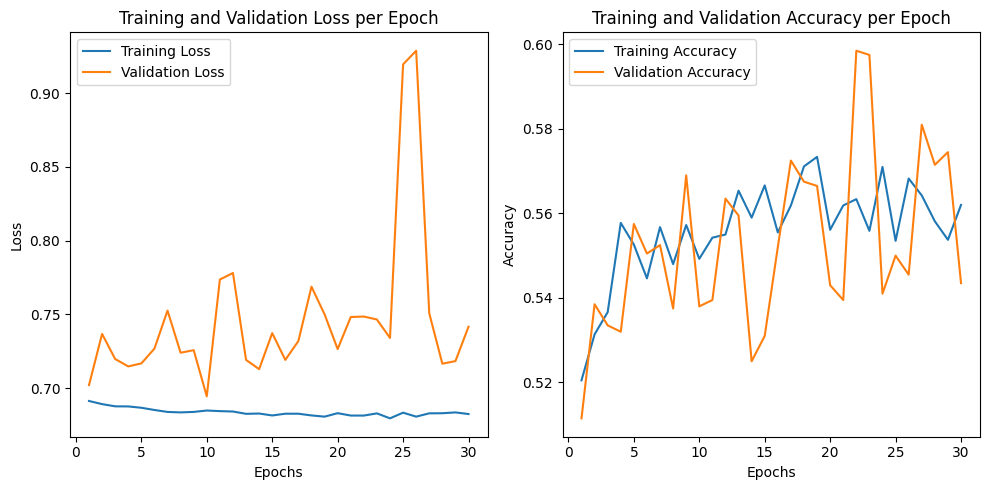

In [26]:
optimizer = optim.SGD(combined_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
criterion = nn.CrossEntropyLoss()

epochs = 30  # Change the number of epochs as needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
combined_model.to(device)
combined_model.train()

train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    combined_model.train()
    for i, data in enumerate(trainloader):

        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = combined_model(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        # print(outputs)
        loss.backward()
        optimizer.step()

        # Calculate training loss
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_train_loss = running_loss / len(trainloader)
    epoch_train_accuracy = correct / total

    train_loss_values.append(epoch_train_loss)
    train_accuracy_values.append(epoch_train_accuracy)

    print(f"Epoch [{epoch + 1}/{epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Accuracy: {100 * epoch_train_accuracy:.2f}%")

    # Validation phase
    combined_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_data in valloader:
            val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
            val_outputs = combined_model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()

    epoch_val_loss = val_running_loss / len(valloader)
    epoch_val_accuracy = val_correct / val_total

    val_loss_values.append(epoch_val_loss)
    val_accuracy_values.append(epoch_val_accuracy)

    print(f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {100 * epoch_val_accuracy:.2f}%")

print("Finished Training")

# Calculate accuracy on test dataset
combined_model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_data in testloader:
        test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
        test_outputs = combined_model(test_inputs)
        _, test_predicted = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {100 * test_accuracy:.2f}%")


# Plotting accuracy and loss per epoch
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_values, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracy_values, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(combined_model.state_dict(), '/content/drive/MyDrive/DeepHW/q1_triplet_model_state_dict.pth')

Mounted at /content/drive
